In [2]:
%run setup.ipynb
random.seed(42)
np.random.seed(42)
from pathlib import Path

In [3]:
def snp_select(chrom='3L', start=15000000, stop=41000000, n=100000):
    
    callset = phase2_ar1.callset_pass_biallelic[chrom]

    #get genotypes
    g = allel.GenotypeChunkedArray(callset['calldata']['genotype'])

    #get positions
    p = allel.VariantChunkedTable(callset['variants'],
                                     names=['POS'],
                                     index='POS')
    pos = p.POS[:]

    #just keep positions within the free region - on 3L 15mb-41mb
    pos_free = pos[(pos > start) * (pos < stop)] 
    free_b = p.index.locate_keys(pos_free)
    g_snp = g.compress(free_b, axis=0)

    #filter - no missing data
    ac = g_snp.count_alleles()
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
    gf = g_snp.compress(flt, axis=0)

    #turn the genotype array into 2D matrix of non_ref alleles per call
    gn = gf.to_n_alt()

    #randomly select snps    
    vidx = np.random.choice(gn.shape[0], n, replace=False)
    vidx.sort()
    gnr = gn.take(vidx, axis=0)
    
    return gnr



def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

In [4]:
pca_data = Path('pca_data.npz')

In [5]:
if pca_data.is_file():
    # file exist
    print('pook')
    pca = np.load('pca_data.npz')
    coords = pca['coords']
    loadings = pca['loadings']
    variance = pca['variance']
else:
    print('snook')
    gnr = snp_select()
    gnu = ld_prune(gnr, size=500, step=200, threshold=.1, n_iter=10)
    coords, model = allel.pca(gnu, n_components=20, scaler='patterson')


snook
iteration 1 retaining 66272 removing 33728 variants
iteration 2 retaining 59390 removing 6882 variants
iteration 3 retaining 57090 removing 2300 variants
iteration 4 retaining 56010 removing 1080 variants
iteration 5 retaining 55349 removing 661 variants
iteration 6 retaining 54942 removing 407 variants
iteration 7 retaining 54646 removing 296 variants
iteration 8 retaining 54380 removing 266 variants
iteration 9 retaining 54209 removing 171 variants
iteration 10 retaining 54075 removing 134 variants


## for figure - run from here

In [6]:
marker_style = {
    'GHcol' : 'D',
    'GHgam' : 'o',
    'BFgam' : 'o',
    'BFcol' : 'D',
    'UGgam' : 'o',
    'GM' : '*',
    'GW' : '*',
    'KE' : '*',
    'CMgam' : 'o',
    'FRgam' : 'o', 
    'GQgam' : 'o', 
    'AOcol' : 'D', 
    'GAgam' : 'o', 
    'GNgam' : 'o', 
    'GNcol' : 'D', 
    'CIcol' : 'D'
}

In [7]:
#get samples
df_samples = pd.read_csv('../phase2.AR1/samples/samples.meta.txt', delimiter='\t')
all_samp=list(df_samples.ox_code)

In [8]:
df_samples

,ox_code,src_code,population,country,region,contributor,contact,year,m_s,sex,n_sequences,mean_coverage
0,AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo_Praso,David Weetman,NaN,2012.0,M,F,95033368,30.99
1,AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo_Praso,David Weetman,NaN,2012.0,M,F,95843804,31.70
2,AA0042-C,Takoradi_C7,GHcol,Ghana,Takoradi,David Weetman,NaN,2012.0,M,F,107420666,35.65
3,AA0043-C,Takoradi_H8,GHcol,Ghana,Takoradi,David Weetman,NaN,2012.0,M,F,95993752,29.46
4,AA0044-C,Takoradi_D10,GHcol,Ghana,Takoradi,David Weetman,NaN,2012.0,M,F,103044262,33.67
5,AA0048-C,Madina_A1,GHgam,Ghana,Madina,David Weetman,NaN,2012.0,S,F,101183648,32.64
6,AA0049-C,Madina_E3,GHcol,Ghana,Madina,David Weetman,NaN,2012.0,M,F,106641272,32.84
7,AA0050-C,Madina_E5,GHgam,Ghana,Madina,David Weetman,NaN,2012.0,S,F,93961924,29.82
8,AA0051-C,Twifo_Praso__C1,GHcol,Ghana,Twifo_Praso,David Weetman,NaN,2012.0,M,F,99910300,33.33
9,AA0052-C,Twifo_Praso__F2,GHcol,Ghana,Twifo_Praso,David Weetman,NaN,2012.0,M,F,100899280,32.29


In [9]:
all_samp=list(df_samples.ox_code)
len(all_samp)

1142

In [10]:
populations = list(phase2_ar1.pop_labels.keys())
populations.remove('colony')

In [11]:
#dictionary+list comprehension to create a dictionary of lists of indexes!
idx_dict = {popz: [i for i, j in enumerate(all_samp) if j == popz] for popz in populations}

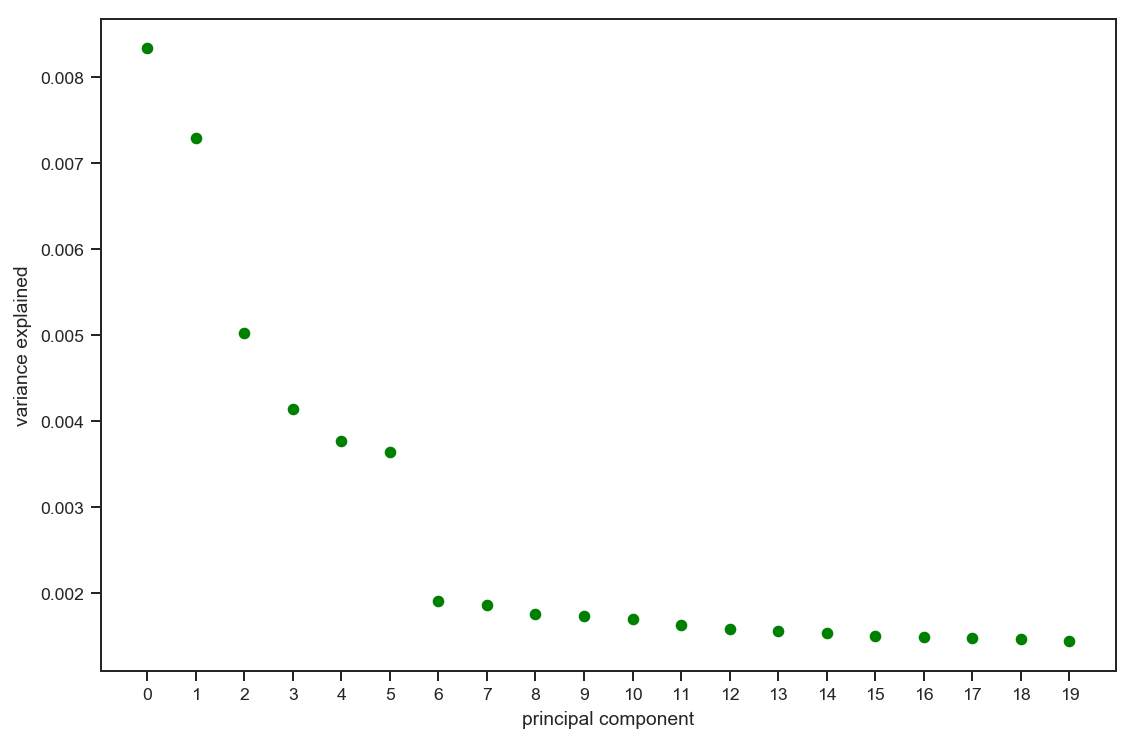

In [12]:
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(121)
if 'variance' in globals():
    ax.plot(variance, 'go')
else:
    ax.plot(model.explained_variance_ratio_, 'go')
ax.set_xlabel("principal component")
ax.set_ylabel("variance explained")
plt.xticks(np.arange(0,20, 1));

In [13]:
def plot_pca_coords(coords, model, pc1, pc2, ax, sample_population):
    sns.despine(ax=ax, offset=5)
    x = coords[:, pc1]
    y = coords[:, pc2]
    for pop in populations:
        flt = (sample_population == pop)
        ax.plot(x[flt], y[flt], marker=marker_style[pop], linestyle=' ', color=phase2_ar1.pop_colors[pop], label=pop, markersize=6, mec='k', mew=0.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model[pc2]*100))
    

def fig_pca(coords, model, title, sample_population):
    # plot coords for PCs 1 vs 2, 3 vs 4
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(231)
    plot_pca_coords(coords, model, 0, 1, ax, sample_population)

    ax = fig.add_subplot(232)
    plot_pca_coords(coords, model, 2, 3, ax, sample_population)
    
    ax = fig.add_subplot(233)
    plot_pca_coords(coords, model, 4, 5, ax, sample_population)
    
    ax = fig.add_subplot(234)
    plot_pca_coords(coords, model, 6, 7, ax, sample_population)
    
    ax = fig.add_subplot(235)
    plot_pca_coords(coords, model, 8, 9, ax, sample_population)
    
    ax = fig.add_subplot(236)
    plot_pca_coords(coords, model, 10, 11, ax, sample_population)

    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    
    fig.suptitle(title, y=1.02)
    fig.tight_layout()

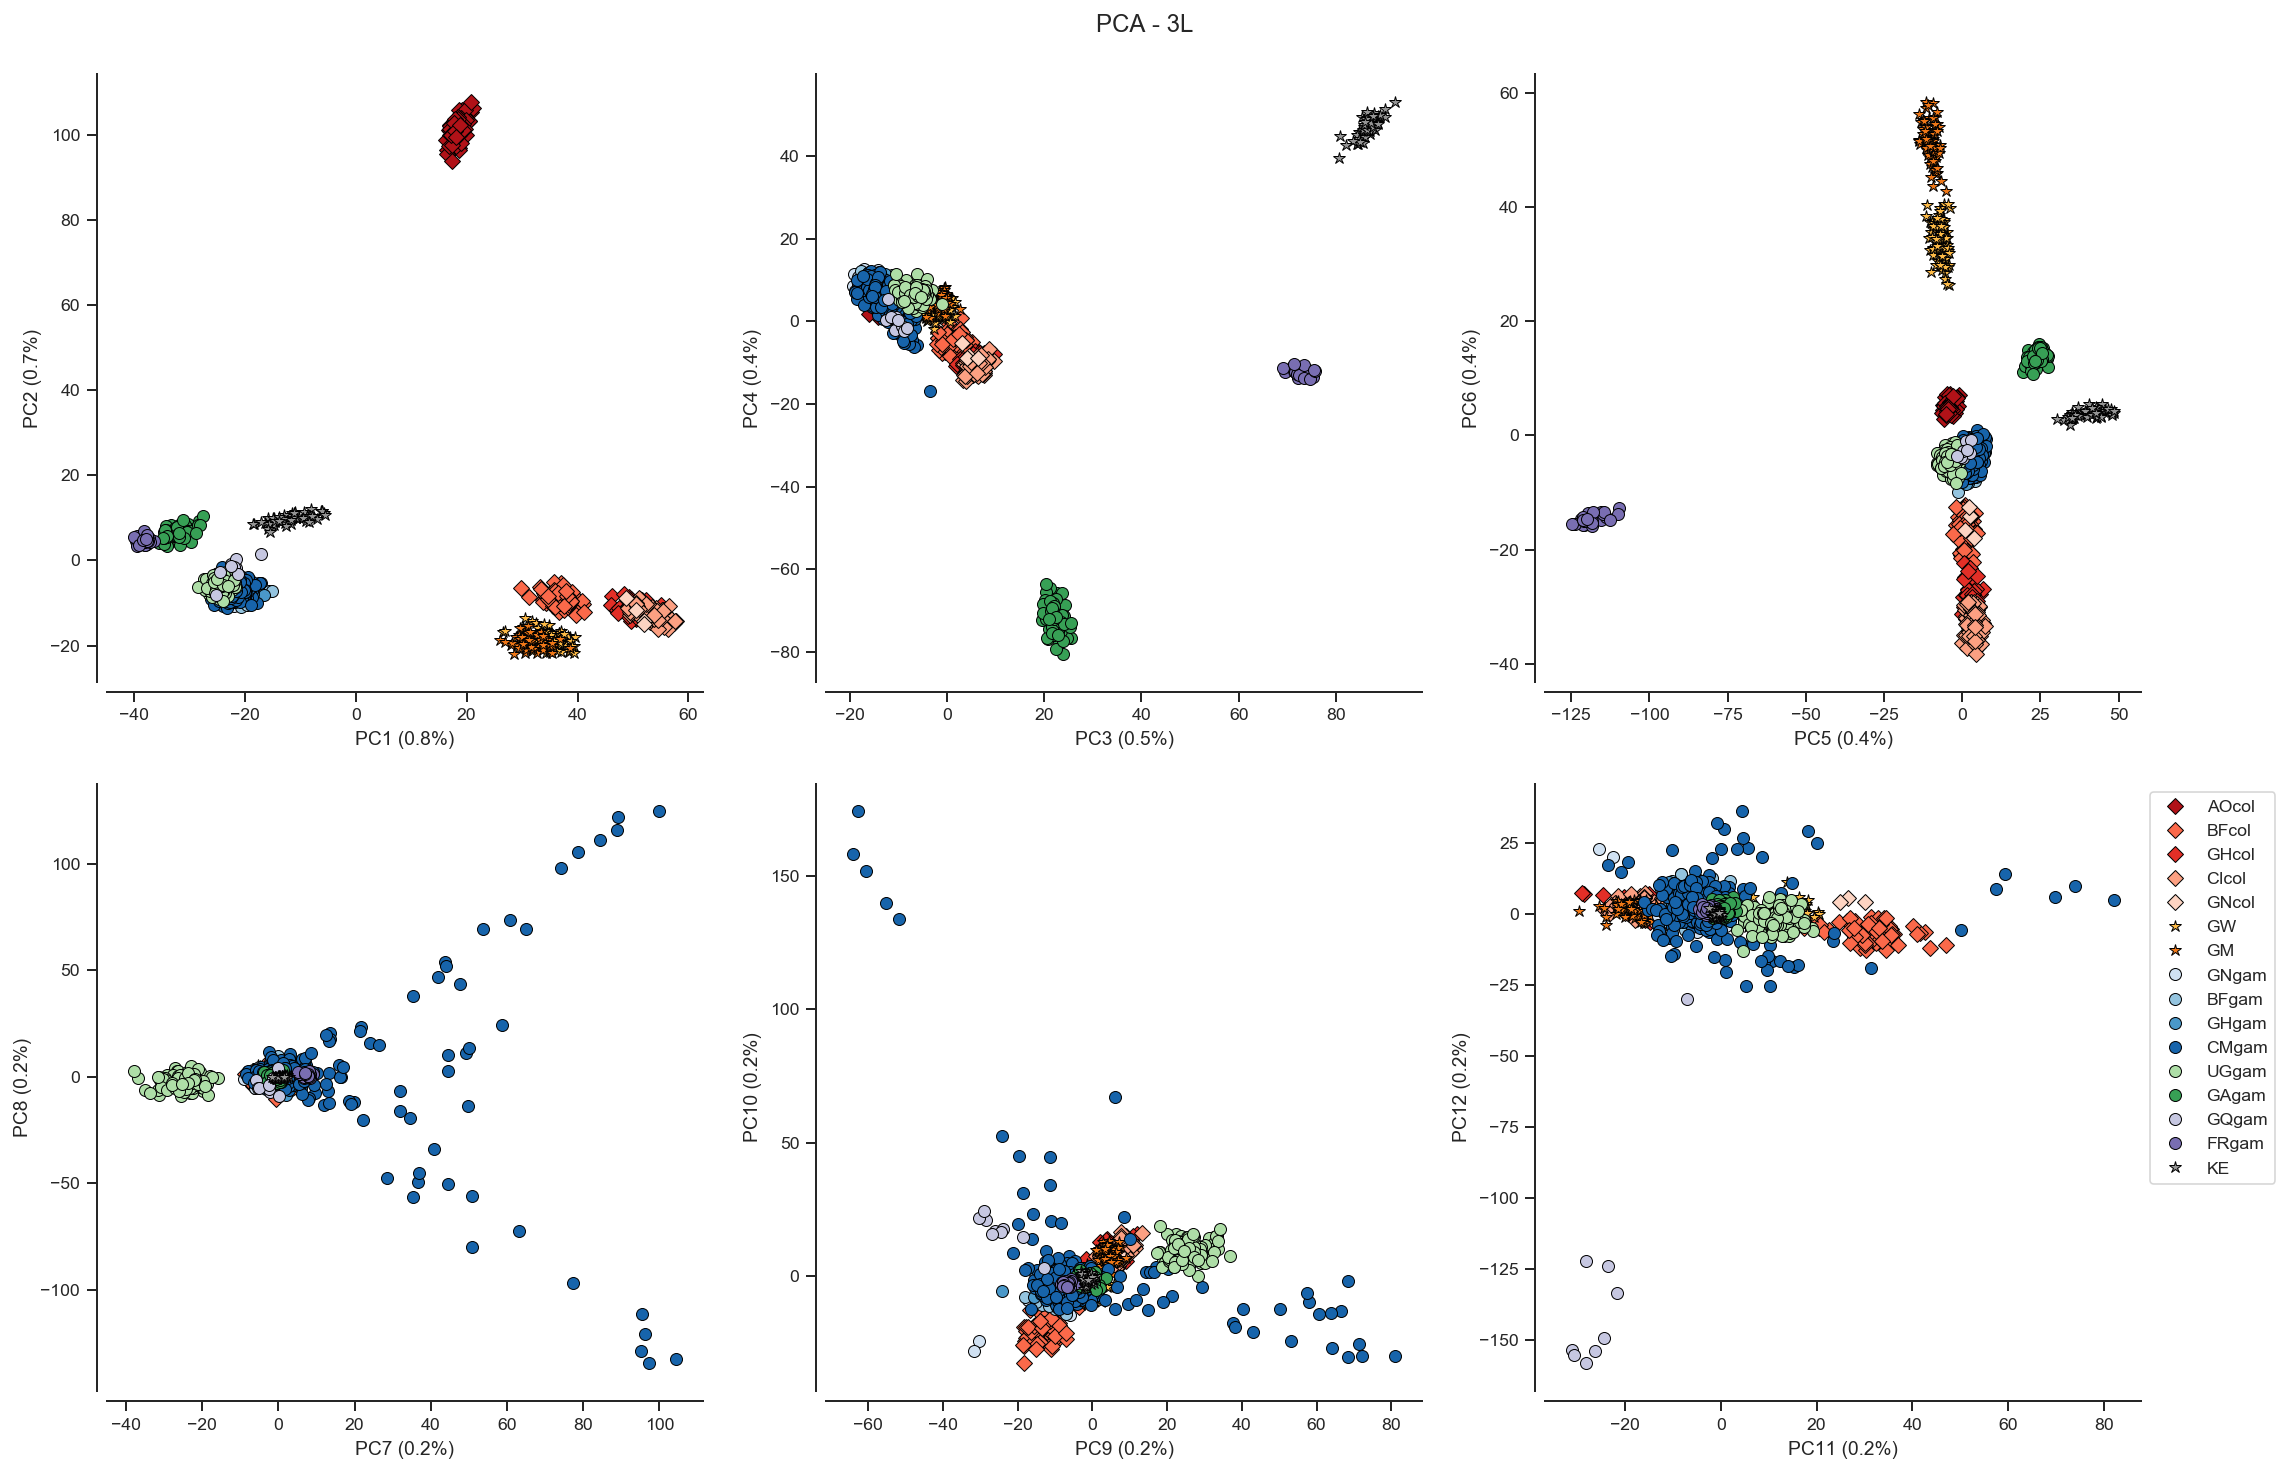

In [14]:
if 'variance' in globals():
    fig_pca(coords, variance ,'PCA - 3L', df_samples.population.values)
else:
    fig_pca(coords, model.explained_variance_ratio_ ,'PCA - 3L', df_samples.population.values)

## main text figure

In [15]:
def fig_main_pca(coords, model, title, sample_population):
    fig = plt.figure(figsize=(12, 5))
    
    ax = fig.add_subplot(121)
    plot_pca_coords(coords, model, 0, 1, ax, sample_population)
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(10)

    ax = fig.add_subplot(122)
    plot_pca_coords(coords, model, 2, 3, ax, sample_population)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(10)
    
    ax.legend(bbox_to_anchor=(1, 1.04), loc='upper left', fontsize=13, framealpha=0.1)
    fig.tight_layout()
    fn = '../artwork/pca_3L_main_text.jpeg'
    fig.savefig(fn, jpeg_quality=100, dpi=100, bbox_inches='tight')

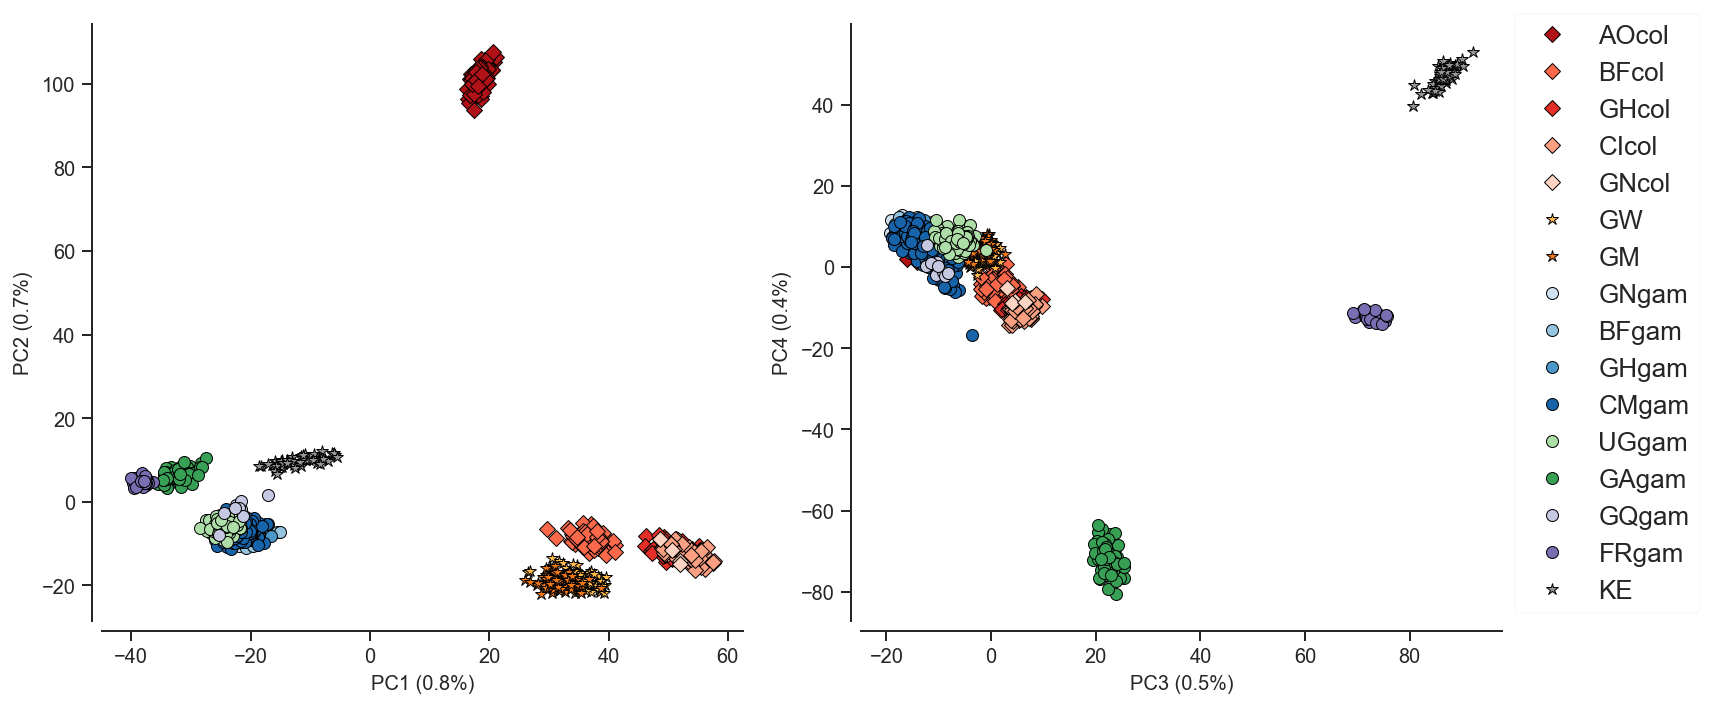

In [16]:
if 'variance' in globals():
    fig_main_pca(coords, variance ,'PCA - 3L', df_samples.population.values)
else:
    fig_main_pca(coords, model.explained_variance_ratio_ ,'PCA - 3L', df_samples.population.values)

In [17]:
np.arange(model.explained_variance_ratio_.shape[0])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

## supplementary figure

In [26]:
def fig_supp_pca(coords, model, title, sample_population):
    
    fig = plt.figure(figsize=(18, 5))
    
    ax = fig.add_subplot(131)
    sns.despine(ax=ax, offset=5)
    if 'variance' in globals():
        x = np.arange(variance.shape[0])
        y = variance * 100
    else:
        x = np.arange(model.shape[0])
        y = model * 100
    ax.bar(x+.2, y, width=.6, align='edge', color='darkgray')
    ax.set_xticks(x+.5)
    ax.set_xticklabels(x+1, fontsize=7)
    ax.set_ylabel('Variance explained (\%)')
    ax.set_xlabel('Principal component')
    ax.set_xlim(0, 20)
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(10)
        
    ax = fig.add_subplot(132)
    plot_pca_coords(coords, model, 4, 5, ax, sample_population)
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(10)

    ax = fig.add_subplot(133)
    plot_pca_coords(coords, model, 6, 7, ax, sample_population)
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(10)
    
    ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left', fontsize=12, framealpha=0.1)
    
    fig.tight_layout()
    fn = '../artwork/pca/pca_3L_supplementary.jpeg'
    fig.savefig(fn, jpeg_quality=100, dpi=100, bbox_inches='tight')

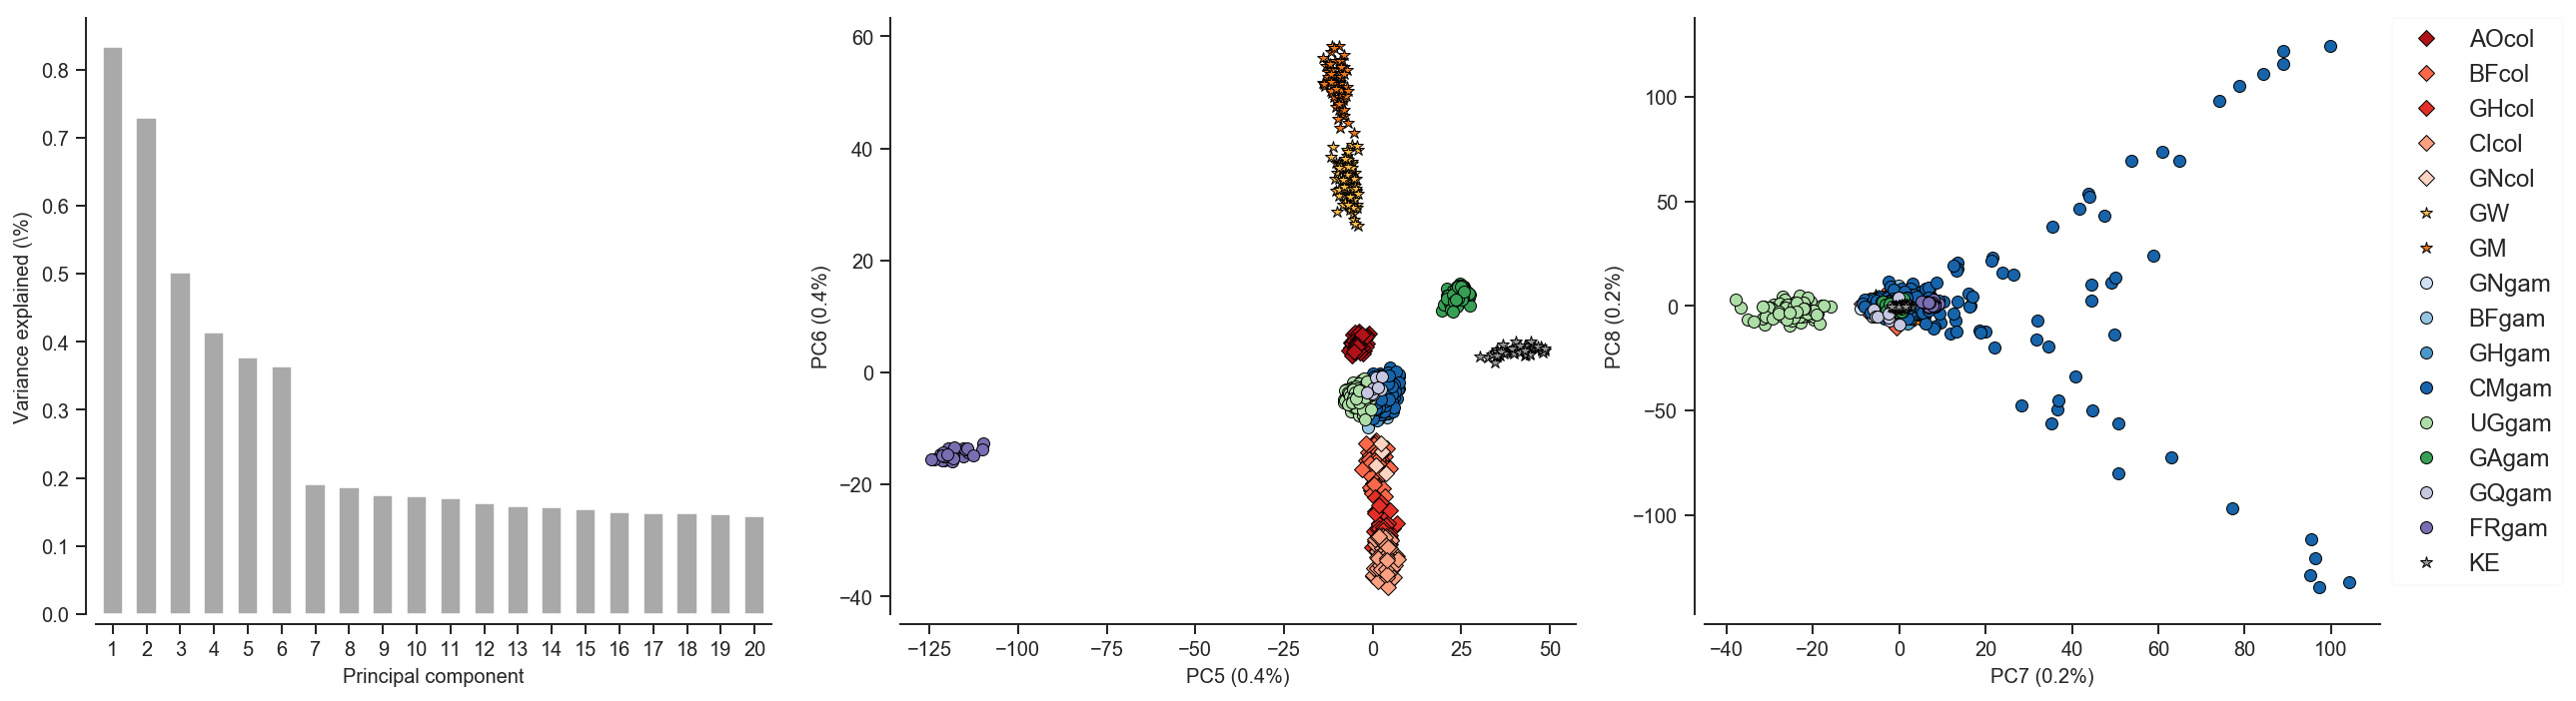

In [27]:
if 'variance' in globals():
    fig_supp_pca(coords, variance ,'PCA - 3L', df_samples.population.values)
else:
    fig_supp_pca(coords, model.explained_variance_ratio_ ,'PCA - 3L', df_samples.population.values)

# new combined main figure 

In [20]:
poop = list(phase2_ar1.pop_labels.values())
poop = poop[:-1]

In [24]:
def fig_supp_pca(coords, model, title, sample_population):
        
    fig = plt.figure(figsize=(18, 10))
        
    ax = fig.add_subplot(232)
    plot_pca_coords(coords, model, 0, 1, ax, sample_population)
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)

    ax = fig.add_subplot(233)
    plot_pca_coords(coords, model, 2, 3, ax, sample_population)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    
    
    ax = fig.add_subplot(234)
    plot_pca_coords(coords, model, 4, 5, ax, sample_population)
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)

    ax = fig.add_subplot(235)
    plot_pca_coords(coords, model, 6, 7, ax, sample_population)
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)    
    
    fig.legend(bbox_to_anchor=(0.67, 0.5), loc='upper left', fontsize=13, framealpha=0.1, labels=poop)
    

    ax = fig.add_subplot(231)
    sns.despine(ax=ax, offset=5)
    if 'variance' in globals():
        x = np.arange(variance.shape[0])
        y = variance * 100
    else:
        x = np.arange(model.shape[0])
        y = model * 100
    ax.bar(x+.2, y, width=.6, align='edge', color='#32aeba')
    ax.set_xticks(x+.5)
    ax.set_xticklabels(x+1, fontsize=7)
    ax.set_ylabel('Variance explained (%)')
    ax.set_xlabel('Principal component')
    ax.set_xlim(0, 20)
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    
        
    fig.tight_layout()
    fn = '../artwork/main_pca.jpeg'
    fig.savefig(fn, jpeg_quality=100, dpi=100, bbox_inches='tight')

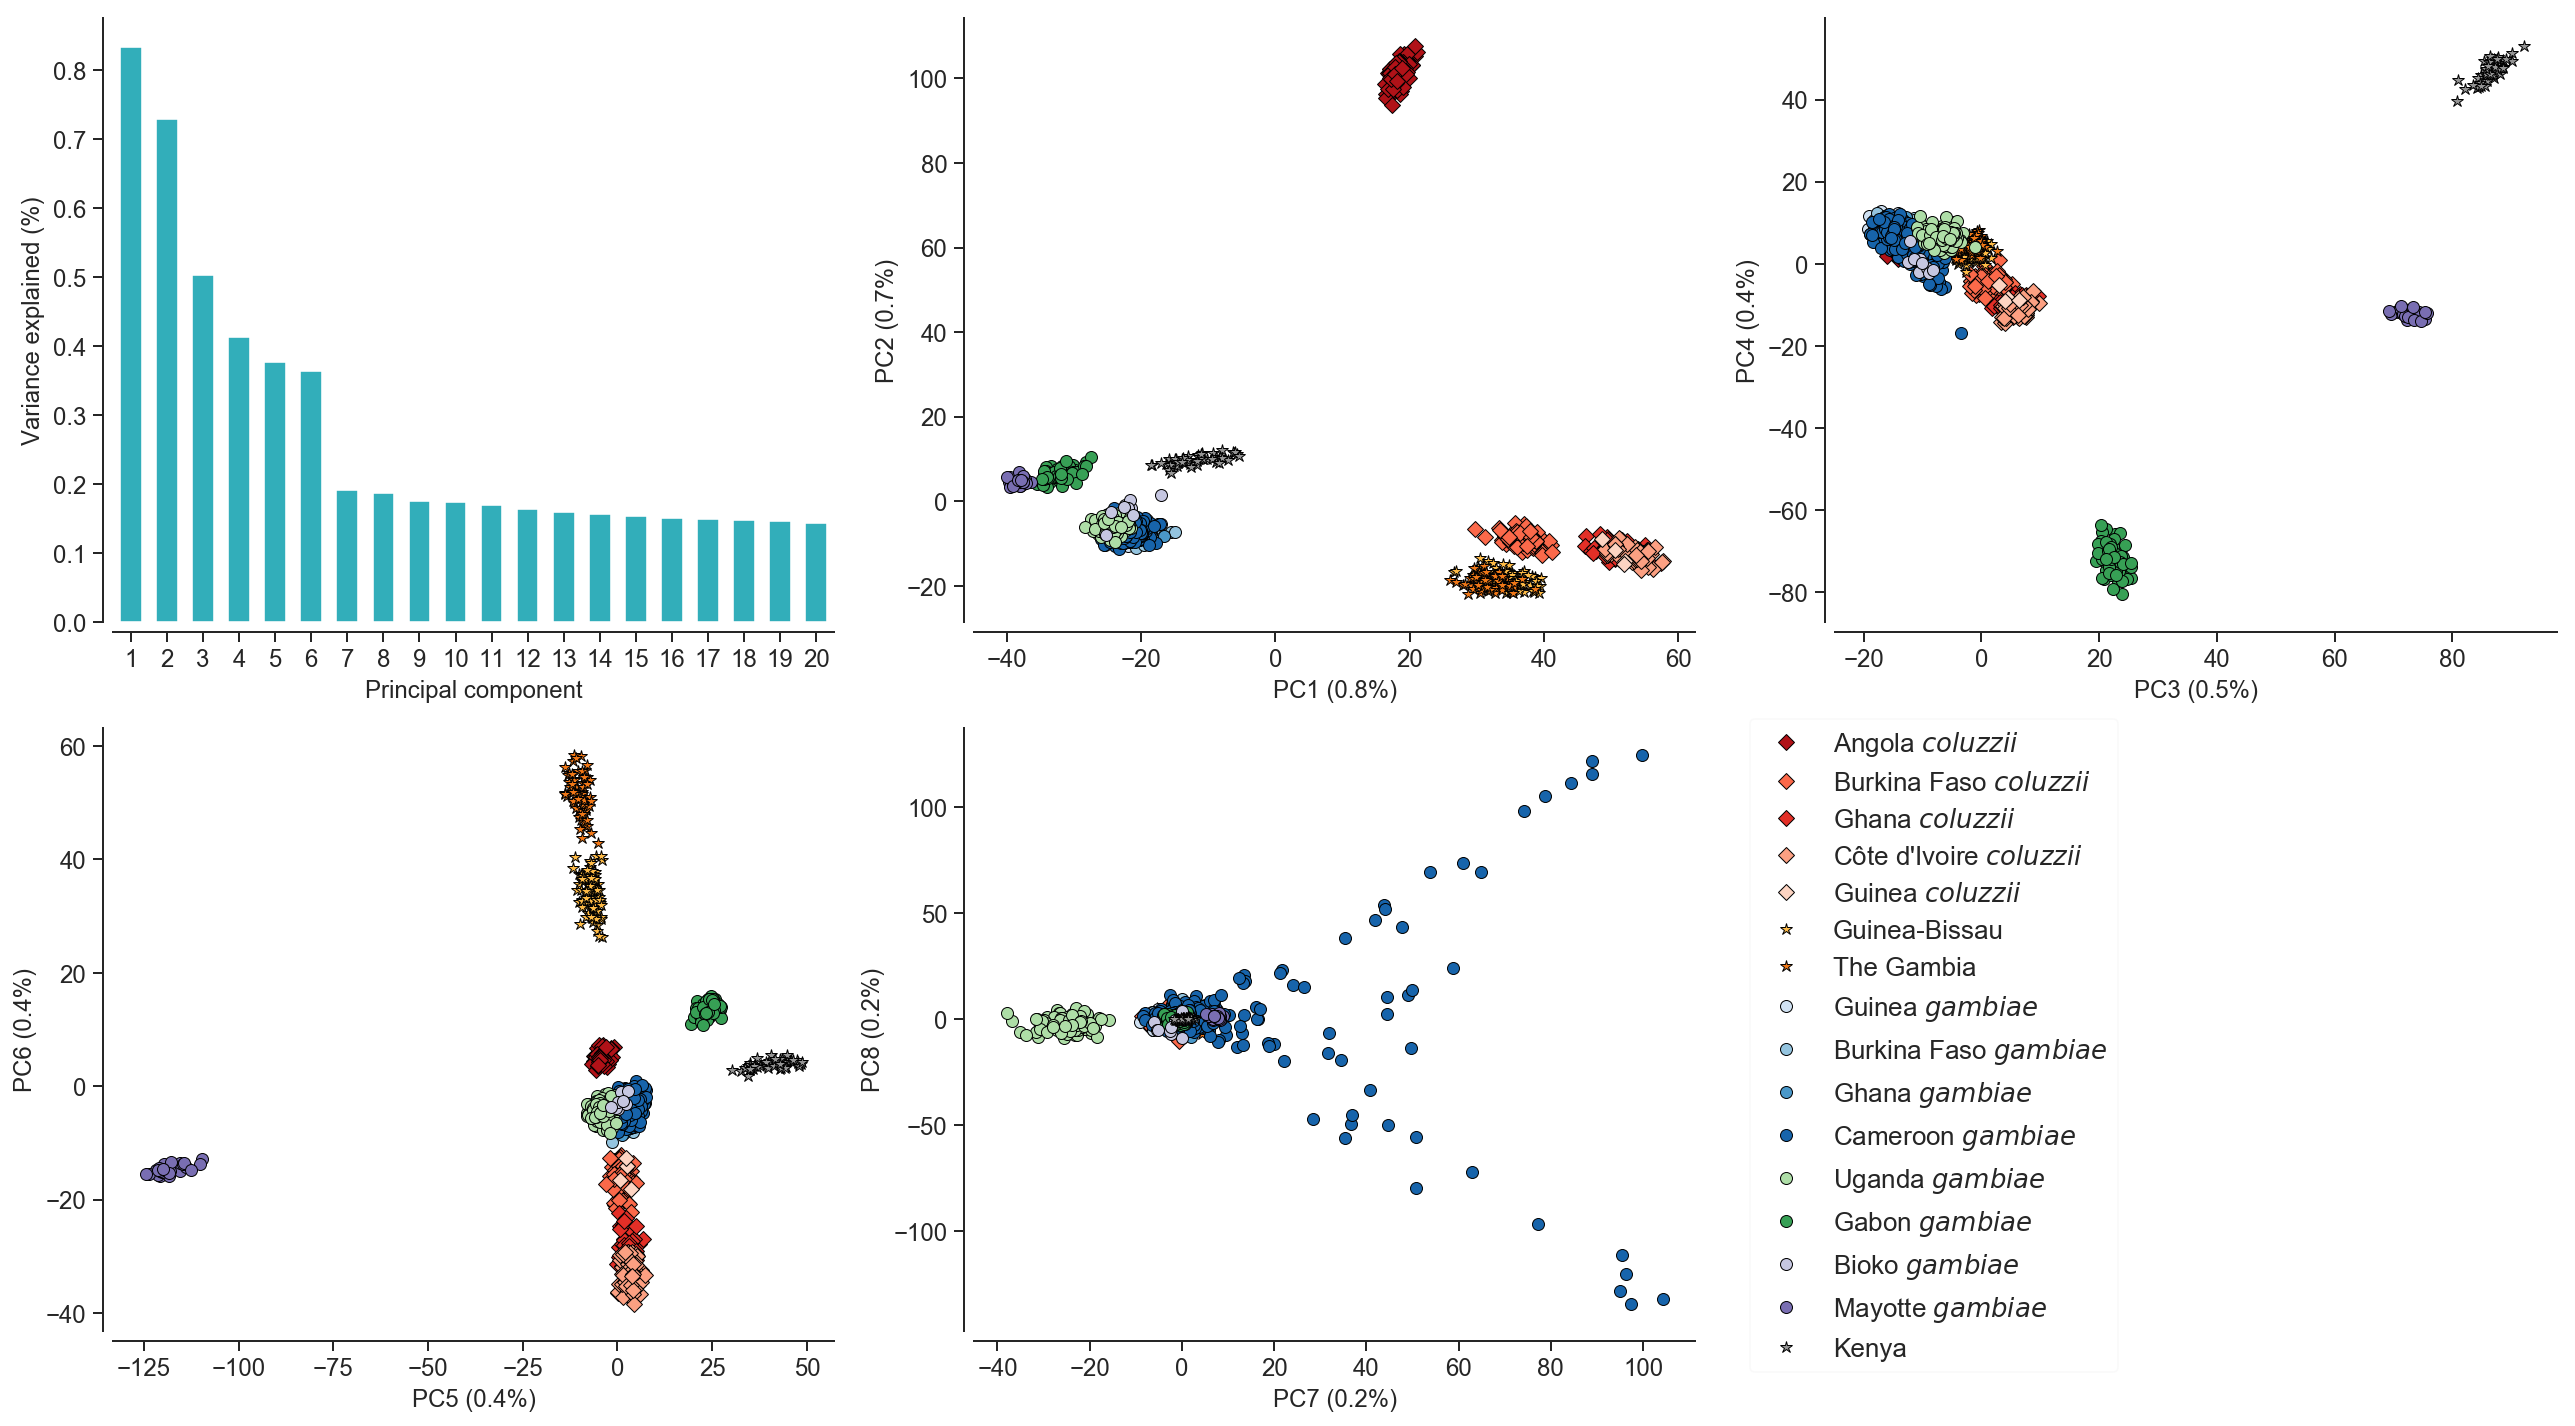

In [25]:
if 'variance' in globals():
    fig_supp_pca(coords, variance ,'PCA - 3L', df_samples.population.values)
else:
    fig_supp_pca(coords, model.explained_variance_ratio_ ,'PCA - 3L', df_samples.population.values)

## bokeh

In [28]:
bmeta = pd.read_table(
    "../phase2.AR1/samples/samples.meta.txt")[['ox_code', 'population', 'country', 'year']]
bmeta.head()

,ox_code,population,country,year
0,AA0040-C,GHcol,Ghana,2012.0
1,AA0041-C,GHcol,Ghana,2012.0
2,AA0042-C,GHcol,Ghana,2012.0
3,AA0043-C,GHcol,Ghana,2012.0
4,AA0044-C,GHcol,Ghana,2012.0


In [29]:
# imports required for `bokeh`
from bokeh.plotting import figure, show, ColumnDataSource, output_file
from bokeh.layouts import gridplot

In [30]:
def plot_pca_coords(coords, variance, pc1, pc2, fig, populations):

    x = coords[:, pc1]
    y = coords[:, pc2]
    
    qdf = bmeta.copy()
    qdf["x"] = x
    qdf["y"] = y
    
    for pop in populations:
        
        source = ColumnDataSource(
            data=qdf.query("population == @pop"))
        
        fig.circle(
            'x', 'y', 
            source=source,
            line_color='black',
            line_width=0.5,
            size=6,
            fill_color=mpl.colors.rgb2hex(phase2_ar1.pop_colors[pop]))
    
    fig.xaxis.axis_label = 'PC {0} ({1:.2f}%)'.format(
        pc1 + 1, 100 * variance[pc1])
    
    fig.yaxis.axis_label = 'PC {0} ({1:.2f}%)'.format(
        pc2 + 1, 100 * variance[pc2])
    
    return fig

In [31]:
components = np.array(range(8)).reshape((2, 2, 2)).tolist()

In [32]:
components

[[[0, 1], [2, 3]], [[4, 5], [6, 7]]]

In [33]:
# This defines what is displayed when the mouse hovers over a point.
# The @ values correspond to values in the table.
TOOLTIPS = [
    ("ox_code", "@ox_code"),
    ("population", "@population"),
    ("collection year", "@year"),
    ("(x, y)", "($x, $y)"),]

In [35]:
output_file("pca_plots.html")
grid = []

for row in components:
    
    l = []
    
    for (c1, c2) in row:

        p = figure(plot_width=400, plot_height=400, tooltips=TOOLTIPS)
        l.append(plot_pca_coords(coords, model.explained_variance_, c1, c2, p, populations))
        
    grid.append(l)

col = gridplot(grid)
show(col)

In [ ]:
from IPython.display import HTML
HTML(filename="../artwork/pca/pca_plots.html")